# Process Throughput Scaling Results

## Imports, Utils, Cfg, Etc

In [21]:
import itertools
import datetime
import glob
import os
import shutil
from statistics import median
from pathlib import Path
from configparser import ConfigParser

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [22]:
ROOT_DIR = Path("/lus/scratch/drozt/repos/ssdev/scale/results/throughput-standard-scaling")
RESULTS_DIR = ROOT_DIR / "just-loop-time"
PROCESSED_RESULTS_DIR = RESULTS_DIR / "my_results"
FORCE_RELOAD = False

In [23]:
sns.set_palette('colorblind')

## Agreed upon axis for study w/ Dragon

In [24]:
ax_client_nodes = [1, 16, 32, 64, 128]
ax_clients_per_node = [1, 8, 16, 32, 64]
ax_db_nodes = [8, 16, 32]
ax_db_cpus = [36]

# dragon pool does well up to 64
ax_tensor_bytes = [8, 16, 32, 1_024, 8_192, 16_384, 32_768, 65_536, 131_072, 262_144, 524_288, 1_048_576]
# ax_tensor_bytes = [1_024, 8_192, 16_384, 32_769,65_538, 131_076, 262_152, 524_304, 1_024_000]

# dragon has managers
# we do not for redis :(
# if time for key db set number of threads
# num_dragon_managers = [1, 2, 4]

ax_iterations = [100]

## Agregate Findings Across MPI Ranks

### Load in Raw Data from Study

In [25]:
def open_and_add_ctx_to_out_file(
    csv_file_path,
    client_nodes,
    clients_per_node,
    db_nodes,
    db_cpus,
    tensor_bytes,
    iterations
):
    df = pd.read_csv(csv_file_path, index_col=None, names=["Rank", "Action", "Time (Seconds)"])
    return df

def aggregate_action_data_in_df(df):
    action_groups = df[["Action", "Time (Seconds)"]].groupby("Action")
    agg_data = {}
    for action, data in action_groups:
        times = data["Time (Seconds)"]
        agg_data.update({
            f"{action}_min": times.min(),
            f"{action}_mean": times.mean(),
            f"{action}_max": times.max()
        })
    return agg_data

In [26]:
def process_throughput_out_data(results_dir, processed_dir):
    composite_data = []
    agg_data = []
    for    client_nodes,    clients_per_node,    db_nodes,    db_cpus,    tensor_bytes,    iterations in tqdm(list(itertools.product(
        ax_client_nodes, ax_clients_per_node, ax_db_nodes, ax_db_cpus, ax_tensor_bytes, ax_iterations
    )), desc="Processing scaling results...", ncols=80):
        scale_out_dir = \
            f"throughput-sess-python-N{client_nodes}-T{clients_per_node}-DBN{db_nodes}-DBCPU{db_cpus}-ITER{iterations}-TB{tensor_bytes}-*"
        dir_, *other = glob.iglob(str(results_dir / scale_out_dir))
        if other:
            print(f"WARNING: got extra, unexpected results dirs: {other};\n"
                   "         Ignoring for now!!")
        dfs = (
            open_and_add_ctx_to_out_file(
                str(csv),
                client_nodes,
                clients_per_node,
                db_nodes,
                db_cpus,
                tensor_bytes,
                iterations
            )
            for csv in glob.iglob(os.path.join(dir_, "rank_*_timing.csv"))
        )
        ranks_data_df = pd.concat(dfs, ignore_index=True)
        assert len(pd.unique(ranks_data_df["Rank"])) == client_nodes * clients_per_node

        specs = {
            "client_nodes": client_nodes,
            "clients_per_node": clients_per_node,
            "database_nodes": db_nodes,
            "database_cpus": db_cpus,
            "iterations": iterations,
            "tensor_bytes": tensor_bytes,
        }
        composite_data.append(ranks_data_df.assign(**specs))
        # agg_data.append(pd.DataFrame([{
        #     **specs,
        #     **aggregate_action_data_in_df(ranks_data_df),
        # }]))

    composite_df = pd.concat(composite_data, ignore_index=True)
    # agg_df = pd.concat(agg_data, ignore_index=True)

    composite_df.to_csv(str(processed_dir / "composite.csv"), index=False)
    # agg_df.to_csv(str(processed_dir / "processed.csv"), index=False)
    return composite_df # , agg_df

def load_from_disk(res_dir):
    return pd.read_csv(str(res_dir / "composite.csv"), index_col=None)
            # pd.read_csv(str(res_dir / "processed.csv"), index_col=None))

if PROCESSED_RESULTS_DIR.is_dir() and not FORCE_RELOAD:
    print(f"Processed results dir {PROCESSED_RESULTS_DIR} detected!")
    print("Loading data from disk")
    composite_df = load_from_disk(PROCESSED_RESULTS_DIR)
else:
    print("Processing and writing data to disk")
    shutil.rmtree(PROCESSED_RESULTS_DIR, ignore_errors=True)
    PROCESSED_RESULTS_DIR.mkdir()
    composite_df = process_throughput_out_data(RESULTS_DIR, PROCESSED_RESULTS_DIR)

Processed results dir /lus/scratch/drozt/repos/ssdev/scale/results/throughput-standard-scaling/just-loop-time/my_results detected!
Loading data from disk


In [27]:
composite_df

,Rank,Action,Time (Seconds),client_nodes,clients_per_node,database_nodes,database_cpus,iterations,tensor_bytes
0,83,client(),0.003653,16,16,8,36,100,1024
1,83,put_tensor,0.028478,16,16,8,36,100,1024
2,83,unpack_tensor,0.021227,16,16,8,36,100,1024
3,83,loop_time,0.049706,16,16,8,36,100,1024
4,83,main(),0.091197,16,16,8,36,100,1024
...,...,...,...,...,...,...,...,...,...
23035,10,client(),0.004236,16,32,16,36,100,1024000
23036,10,put_tensor,1.522151,16,32,16,36,100,1024000
23037,10,unpack_tensor,1.164797,16,32,16,36,100,1024000
23038,10,loop_time,2.686953,16,32,16,36,100,1024000


In [28]:
# agg_df[(agg_df["client_nodes"] == 32) & (agg_df["clients_per_node"] == 32)][["database_nodes", "tensor_bytes", "put_tensor_mean", "unpack_tensor_mean"]]

## Plot Findings

In [29]:
nodes_and_client_per_node_to_data = {
    n_and_cpn: df for n_and_cpn, df 
    in (composite_df[composite_df["database_cpus"] == 36]
        .groupby(['client_nodes', 'clients_per_node']))
}

In [30]:
NODES = 16
CLIENTS_PER_NODE = 16
ITERATIONS = 100

def make_throughput_per_client_dataset(df, x, y, hue):
    return pd.DataFrame([{
        hue: nodes,
        x: msg_size,
        y: (
            (msg_size * ITERATIONS) / group['Time (Seconds)']
        ).mean() / 1e9
    }
    for (nodes, msg_size), group
    in df.groupby(["database_nodes", "tensor_bytes"])
    ])

def make_observed_throughput_dataset(df, x, y, hue):
    return pd.DataFrame([{
        hue: nodes,
        x: msg_size,
        y: ((msg_size * ITERATIONS * NODES * CLIENTS_PER_NODE)  # Number of bytes
            / group['Time (Seconds)'].max()  # divied by time for all ranks to reach barrier
            / 1e9  # bytes -> gigs
           )
    }
    for (nodes, msg_size), group
    in df.groupby(["database_nodes", "tensor_bytes"])
    ])

plot_data = nodes_and_client_per_node_to_data[(NODES, CLIENTS_PER_NODE)]
client_num_title = f"({NODES} Nodes, {CLIENTS_PER_NODE} Clients per Node)"

### Put Tensor Times

In [31]:
put_tensor_data = plot_data[plot_data["Action"] == "put_tensor"]

In [32]:
put_tensor_data
# for _, df_ in put_tensor_data.groupby(["database_nodes", "tensor_bytes"]):
#     print("=" * 80)
#     # print(df_.describe())
#     print(df_)
#     print("=" * 80)

,Rank,Action,Time (Seconds),client_nodes,clients_per_node,database_nodes,database_cpus,iterations,tensor_bytes
1,83,put_tensor,0.028478,16,16,8,36,100,1024
6,239,put_tensor,0.045116,16,16,8,36,100,1024
11,81,put_tensor,0.028752,16,16,8,36,100,1024
16,252,put_tensor,0.024529,16,16,8,36,100,1024
21,0,put_tensor,0.015383,16,16,8,36,100,1024
...,...,...,...,...,...,...,...,...,...
7656,215,put_tensor,1.575048,16,16,16,36,100,1024000
7661,63,put_tensor,1.391000,16,16,16,36,100,1024000
7666,157,put_tensor,1.699762,16,16,16,36,100,1024000
7671,176,put_tensor,1.371745,16,16,16,36,100,1024000


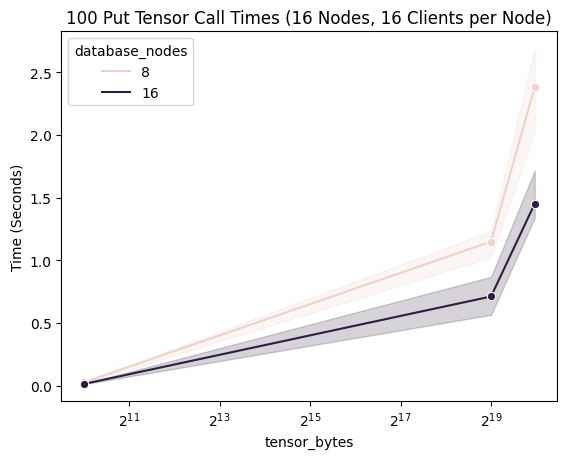

In [33]:
x = 'tensor_bytes'
y = 'Time (Seconds)'
hue = 'database_nodes'

put_call_time_data = put_tensor_data[[x, y, hue]]
plot = sns.lineplot(put_call_time_data, x=x, y=y, hue=hue,
                    errorbar=("pi", 50), marker='o')
plot.set(title=f"{ITERATIONS} Put Tensor Call Times {client_num_title}")
plot.set_xscale('log', base=2)

### Put Tensor Throughput Per Client

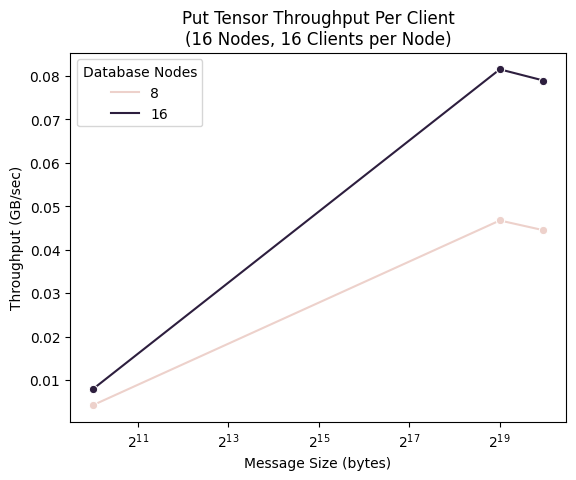

In [34]:
x = "Message Size (bytes)"
y = "Throughput (GB/sec)"
hue = "Database Nodes"

put_throughput_df = make_throughput_per_client_dataset(put_tensor_data, x, y, hue)
plot = sns.lineplot(put_throughput_df, x=x, y=y, hue=hue,
                    marker='o')
plot.set(title=f"Put Tensor Throughput Per Client\n{client_num_title}")
plot.set_xscale("log", base=2)

### Put Tensor Throughput Per DB

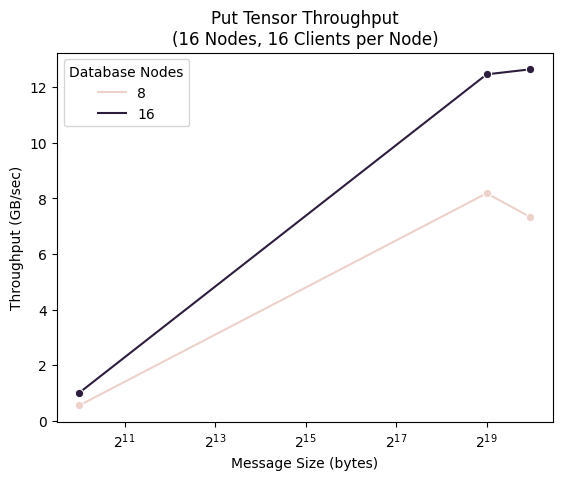

In [35]:
plot = sns.lineplot(make_observed_throughput_dataset(put_tensor_data, x, y, hue),
                    x=x, y=y, hue=hue,
                    marker='o')
plot.set(title=f"Put Tensor Throughput\n{client_num_title}")
plot.set_xscale('log', base=2)

### Get Tensor Times

In [36]:
get_tensor_data = plot_data[plot_data["Action"] == "unpack_tensor"]

In [37]:
get_tensor_data

,Rank,Action,Time (Seconds),client_nodes,clients_per_node,database_nodes,database_cpus,iterations,tensor_bytes
2,83,unpack_tensor,0.021227,16,16,8,36,100,1024
7,239,unpack_tensor,0.024631,16,16,8,36,100,1024
12,81,unpack_tensor,0.022063,16,16,8,36,100,1024
17,252,unpack_tensor,0.020343,16,16,8,36,100,1024
22,0,unpack_tensor,0.012069,16,16,8,36,100,1024
...,...,...,...,...,...,...,...,...,...
7657,215,unpack_tensor,0.873085,16,16,16,36,100,1024000
7662,63,unpack_tensor,0.903713,16,16,16,36,100,1024000
7667,157,unpack_tensor,1.118193,16,16,16,36,100,1024000
7672,176,unpack_tensor,0.983304,16,16,16,36,100,1024000


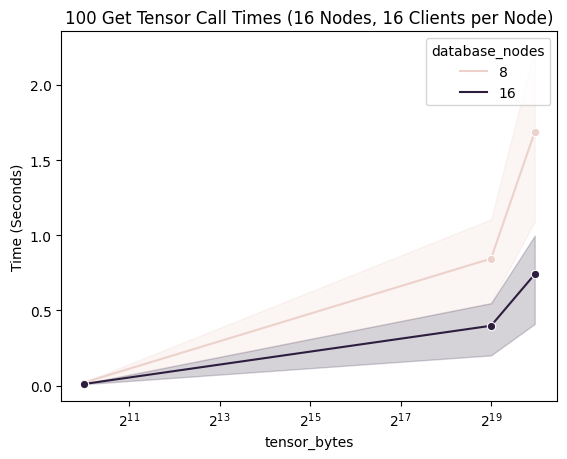

In [38]:
x = 'tensor_bytes'
y = 'Time (Seconds)'
hue = 'database_nodes'

get_call_time_data = get_tensor_data[[x, y, hue]]
plot = sns.lineplot(get_call_time_data, x=x, y=y, hue=hue,
                    errorbar=("pi", 50), marker='o')
plot.set(title=f"{ITERATIONS} Get Tensor Call Times {client_num_title}")
plot.set_xscale('log', base=2)
# plot.set_xticks(ax_tensor_bytes)
# plot.set_yscale('log', base=2)

### Get Tensor Throughput Per Client

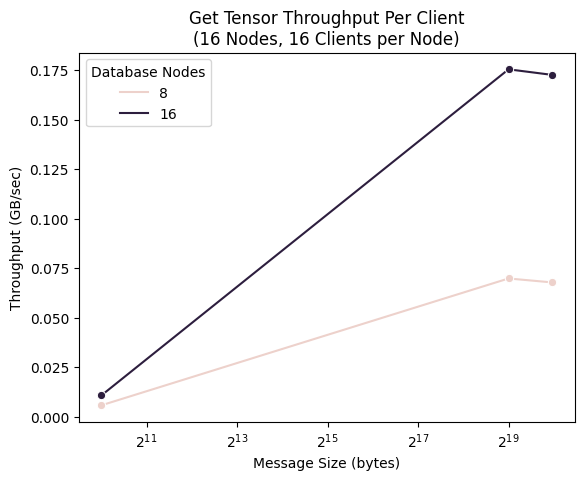

In [39]:
x = "Message Size (bytes)"
y = "Throughput (GB/sec)"
hue = "Database Nodes"

get_throughput_df = make_throughput_per_client_dataset(get_tensor_data, x, y, hue)
plot = sns.lineplot(get_throughput_df, x=x, y=y, hue=hue,
                    marker='o')
plot.set(title=f"Get Tensor Throughput Per Client\n{client_num_title}")
plot.set_xscale('log', base=2)

### Get Tensor Throughput Per DB

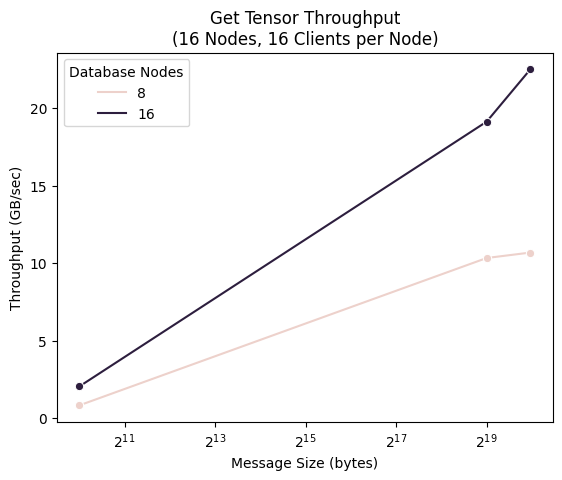

In [40]:
plot = sns.lineplot(make_observed_throughput_dataset(get_tensor_data, x, y, hue),
                    x=x, y=y, hue=hue,
                    marker='o')
plot.set(title=f"Get Tensor Throughput\n{client_num_title}")
plot.set_xscale('log', base=2)